# COVID-19 modelamiento Santiago, Chile
Autor: Taco de Wolff\
Fecha: 18 abril 2020

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import epidemia

In [2]:
df_infectados = pd.read_csv('../data/chile_minsal_infectados.csv', sep=';', index_col=0)
df_infectados = df_infectados.transpose()
df_infectados.index = pd.to_datetime(df_infectados.index, format='%d-%b') + pd.offsets.DateOffset(years=120)

df_fallecidos = pd.read_csv('../data/chile_minsal_fallecidos.csv', sep=';', index_col=0)
df_fallecidos = df_fallecidos.transpose()
df_fallecidos.index = pd.to_datetime(df_fallecidos.index, format='%d-%b') + pd.offsets.DateOffset(years=120)

df_hospitalizados = pd.read_csv('../data/chile_hospitalizados.csv', sep=';', index_col=0)
df_hospitalizados.index = pd.to_datetime(df_hospitalizados.index, dayfirst=True)
df_hospitalizados = df_hospitalizados[:np.datetime64('2020-03-26')]

data = pd.DataFrame({
    'I_cases': df_infectados['Región Metropolitana'],
    'D': df_fallecidos['Región Metropolitana'],
    #'H_total': df_hospitalizados['Total'],
})

In [3]:
x = [
    7,      # E0
    4,      # Im0
    0.2,    # H0
    0.38,   # CE
    0.75,   # CIm
    0.165,  # βI
    0.2,    # γE
    0.1,    # γIm
    0.1,    # γI
    0.1667, # γH
    0.1,    # γHc
    0.5,    # φIR
    0.85,   # φHR
]

x_bounds = [
    (0,20.0),
    (0,20.0),
    (0,2.0),
    (0.0,0.4),  
    (0.0,0.9),
    (0.0,0.75),
    (0.17,0.25),
    (0.07,0.14),
    (0.07,0.14),
    (0.07,0.14),
    (0.0625,0.14),
    (0.3,0.9),
    (0.3,0.9),
]

def x_params(E0, Im0, H0, CE, CIm, βI, γE, γIm, γI, γH, γHc, φIR, φHR):
    y0['E'] = E0 * y0['I']
    y0['Im'] = Im0 * y0['I']
    y0['H'] = H0 * y0['I']
    y0['Hc'] = 0.33 * y0['H']
    y0['H_total'] = y0['H'] + y0['Hc']

    #λ1 = np.datetime64('2020-04-01')
    #κ1 = 0.1
    #α2 = 0.5
    #α = lambda t: 1.0 if t < λ1 else α2 + (1.0-α2)*np.exp(-κ1*(t-λ1)/np.timedelta64(1,'D'))
    α = lambda t: 0.75
    return y0, lambda t: {
        'βE': α(t)*CE*βI,
        'βIm': α(t)*CIm*βI,
        'βI': α(t)*βI,
        'βH': 0.0,
        'βHc': 0.0,
        'γE': γE,
        'γIm': γIm,
        'γI': γI,
        'γH': γH,
        'γHc': γHc,
        'μb': 3.57e-5,
        'μd': 1.57e-5,
        'φEI': 0.5,
        'φIR': φIR,
        'φHR': φHR,
        'φD': 0.2,
    }

t0 = data.index.max() - np.timedelta64(14,'D')
tmax = data.index.max() + np.timedelta64(14,'D')

D0 = data['D'].loc[t0]
I0_cases = data['I_cases'].loc[t0] - D0
I0 = (1-0.14)*I0_cases
y0 = {'S': 5.624e6, 'E': 0, 'Im': 0, 'I': I0, 'H': 0, 'Hc': 0, 'R': 0, 'D': D0, 'I_cases': I0_cases, 'D_cases': D0}
print(y0)

model = epidemia.ModelReport2()
santiago = epidemia.Epidemic(model, t0, tmax, data=data)

{'S': 5624000.0, 'E': 0, 'Im': 0, 'I': 2417.46, 'H': 0, 'Hc': 0, 'R': 0, 'D': 21.0, 'I_cases': 2811.0, 'D_cases': 21.0}


In [4]:
options = {
    'annealing': {
        'seed': 1234567,
    },
    'L-BFGS-B': {
        'eps': 1e-12,
    },
}

for method in ['annealing', 'L-BFGS-B']:
    opt = {}
    if method in options:
        opt = options[method]
    x = santiago.optimize(x, x_bounds, x_params, method=method, **opt)

santiago.print_x_params(x, x_bounds, x_params)
santiago.print_params()

Parameter,Value,Range
E0,1.246,"[0, 20]"
Im0,3.596,"[0, 20]"
H0,0.3572,"[0, 2]"
CE,0.1441,"[0, 0.4]"
CIm,0.5914,"[0, 0.9]"
βI,0.1001,"[0, 0.75]"
γE,0.17,"[0.17, 0.25]"
γIm,0.103,"[0.07, 0.14]"
γI,0.09758,"[0.07, 0.14]"
γH,0.07367,"[0.07, 0.14]"


Parameter,Value
βE,0.01082
βIm,0.04442
βI,0.07511
βH,0
βHc,0
γE,0.17
γIm,0.103
γI,0.09758
γH,0.07367
γHc,0.06326


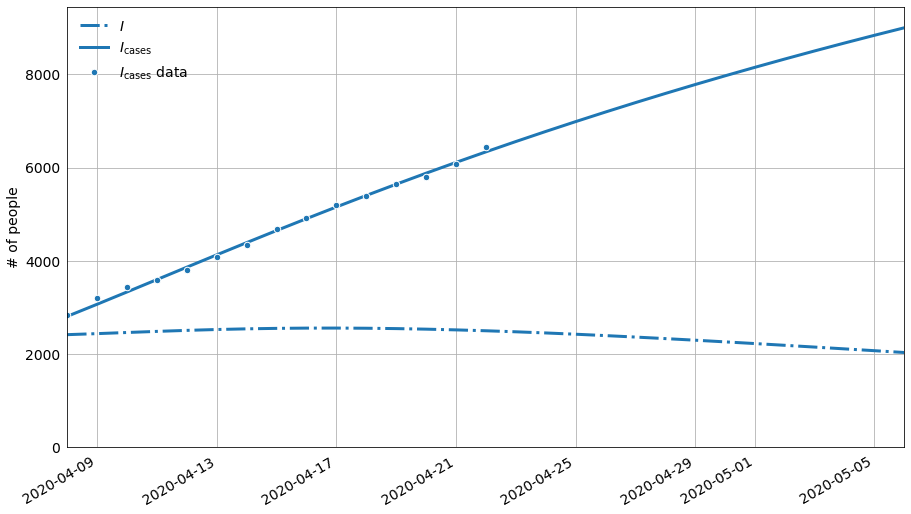

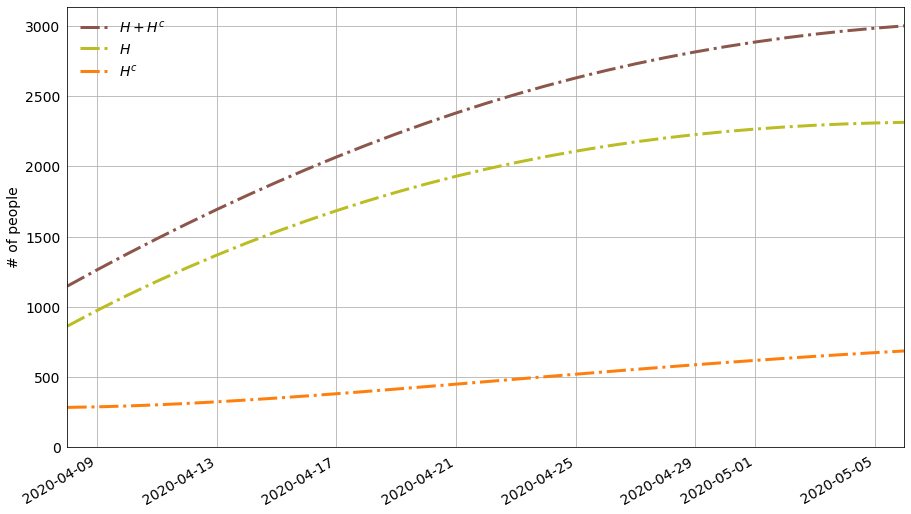

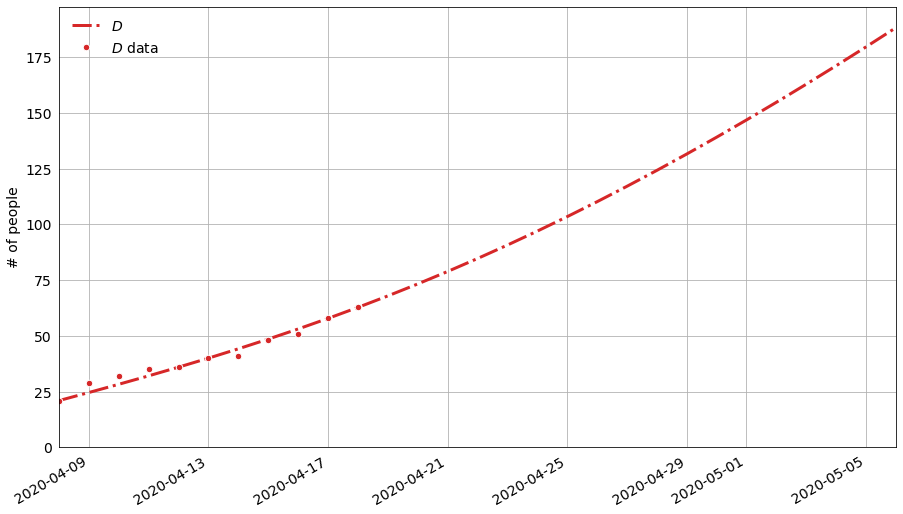

Parameter,Value,Date
max(I),2558,2020-04-17
max(H),2313,2020-05-06
max(Hc),686,2020-05-06
max(D),188,2020-05-06


In [5]:
santiago.plot(cols=['I', 'I_cases'])
santiago.plot(cols=['H_total', 'H', 'Hc'])
santiago.plot(cols=['D'])
santiago.print_stats()

In [7]:
santiago.param_sensitivity(x, x_bounds, x_params)

,*,D,I_cases
E0,0.00447866,0.000596692,0.00821492
Im0,0.000187333,7.6321e-05,0.000374667
H0,0.0122682,0.0289566,1.56129e-05
CE,0.000187349,0.000222043,0.000487455
CIm,0.000988814,0.000520429,0.00208865
βI,0.00773335,0.00489189,0.0170071
γE,0.0344063,0.00437842,0.0628452
γIm,0.00245982,0.000575925,0.00385106
γI,0.0041529,0.0132602,0.00252574
γH,0.000263676,0.000631436,0


In [8]:
santiago.error()

,*,D,I_cases
N,26,11,15
AE,753.173,17.2543,735.918
SE,59032.4,56.3301,58976.1
APE,0.661625,0.487366,0.174259
SPE,0.0546722,0.0508767,0.00379553
MAE,28.9682,1.56857,49.0612
MSE,2270.48,5.12092,3931.74
MAPE,0.0254471,0.044306,0.0116173
MSPE,0.00210278,0.00462516,0.000253035
